# 1. Çalışma Ortamı Hazırlığı

In [1]:
!pip install flexml autogluon --quiet


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from flexml import Regression
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error

# Surpress Warnings
import logging
import warnings
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)


DATA_PATH = "/kaggle/input/datathon-2025/"

In [3]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
test_df = pd.read_csv(DATA_PATH+"test.csv")

train_df['event_time'] = pd.to_datetime(train_df['event_time']).dt.tz_localize(None)
test_df['event_time'] = pd.to_datetime(test_df['event_time']).dt.tz_localize(None)

# 2. Veri Analizi

In [4]:
id_cols = ["product_id", "category_id", "user_id", "user_session"]

for c in id_cols:
    train_vals = set(train_df[c].unique())
    test_vals = set(test_df[c].unique())
    common = train_vals & test_vals
    print(f"{c}:")
    print(f"  Train unique: {len(train_vals)}")
    print(f"  Test unique : {len(test_vals)}")
    print(f"  Common      : {len(common)}\n")

product_id:
  Train unique: 26470
  Test unique : 17450
  Common      : 14538

category_id:
  Train unique: 448
  Test unique : 433
  Common      : 429

user_id:
  Train unique: 51821
  Test unique : 22665
  Common      : 4620

user_session:
  Train unique: 70736
  Test unique : 30789
  Common      : 210



***Test veri setinde; eğitim veri setinde bulunan user_session'lar bulunuyor***

In [5]:
def extend_with_test(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    """Eğitim ve test veri setlerindeki ortak seanslara ait verileri test verisinden eğitim verisine aktarır"""
    train_values = train_df.set_index("user_session")["session_value"].to_dict()

    mask = test_df["user_session"].isin(train_values.keys())
    test_common = test_df[mask].copy()

    test_common["session_value"] = test_common["user_session"].map(train_values)

    df_extended = pd.concat([train_df, test_common], ignore_index=True)

    return df_extended

train_df = extend_with_test(train_df, test_df)

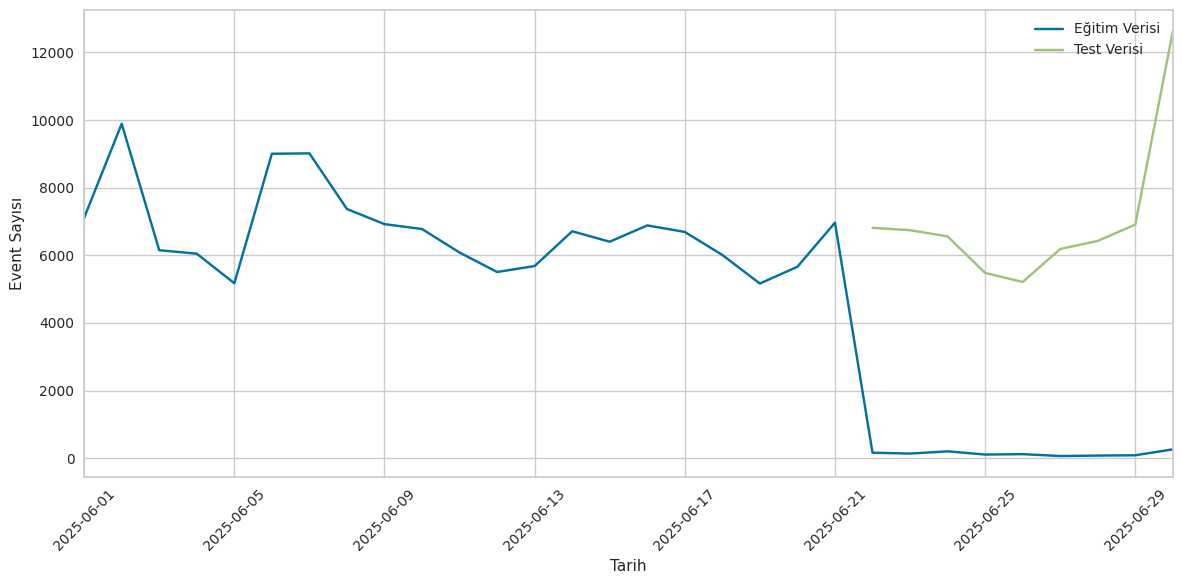

In [6]:
# Son tarih
end_date = pd.to_datetime("2025-06-30").date()

# Günlük gruplama ve son günü filtrele
train_date_counts = train_df.groupby(train_df["event_time"].dt.date).size()
train_date_counts = train_date_counts[train_date_counts.index <= end_date]

test_date_counts = test_df.groupby(test_df["event_time"].dt.date).size()
test_date_counts = test_date_counts[test_date_counts.index <= end_date]

plt.figure(figsize=(12,6))

plt.plot(train_date_counts.index, train_date_counts.values, label="Eğitim Verisi")
plt.plot(test_date_counts.index, test_date_counts.values, label="Test Verisi")

plt.xlabel("Tarih")
plt.ylabel("Event Sayısı")
plt.legend()

# X eksenini tarih formatında ayarla
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# X eksenini manuel sınırla
plt.xlim([min(train_date_counts.index.min(), test_date_counts.index.min()), end_date])

plt.tight_layout()
plt.show()

***Haziran ayının ilk 20 günü var ve son 10 gününü tahmin etmemiz bekleniyor, Eğitim verisinde 21 Haziran sonrası gözüken az miktardaki veri sayısı ortak seanslardır***

In [7]:
train_df.groupby("event_type").agg(
    count=("event_type", "size"),
    avg_session_value=("session_value", "mean"),
    median_session_value=("session_value", "median")
).sort_values('avg_session_value', ascending=False)

,count,avg_session_value,median_session_value
event_type,,,
BUY,14585,178.777727,138.96
REMOVE_CART,25997,80.496233,39.40
ADD_CART,42632,78.938891,47.44
VIEW,59237,50.290357,30.16


***'BUY' event_type değerleri önemli olacak gibi duruyor***

In [8]:
train_df[train_df["user_session"] == "SESSION_158779"].reset_index(drop=True)

,event_time,event_type,product_id,category_id,user_id,user_session,session_value
0,2025-06-19 10:23:07,ADD_CART,PROD_011223,CAT_00054,USER_097562,SESSION_158779,90.29
1,2025-06-19 10:35:45,ADD_CART,PROD_010260,CAT_00011,USER_097562,SESSION_158779,90.29
2,2025-06-19 11:11:13,ADD_CART,PROD_030747,CAT_00144,USER_097562,SESSION_158779,90.29
3,2025-06-19 10:38:33,REMOVE_CART,PROD_020795,CAT_00073,USER_097562,SESSION_158779,90.29
4,2025-06-19 10:47:07,REMOVE_CART,PROD_031547,CAT_00090,USER_097562,SESSION_158779,90.29
5,2025-06-19 10:47:12,REMOVE_CART,PROD_020796,CAT_00073,USER_097562,SESSION_158779,90.29
6,2025-06-19 10:55:37,BUY,PROD_019159,CAT_00090,USER_097562,SESSION_158779,90.29


***Bir user_session için:***

*   Her satırda aynı user_session değeri olduğundan, tek bir session_value değeri olabilir.
*   Test verisinde bu session_value mevcutsa, bu değeri doldurup train veri setine aktarabiliriz.
*   Eğitimde bu değer kullanılabilir ve prediction yaparken, eksik olanlar için eğitim veri setindeki değer ile doldurulabilir.

# 3. Özellik Mühendisliği

***Seanslar için kullanılacak özellikler;***

- **Seans bazlı özellikler**

    - Toplam event sayısı: oturumdaki tüm işlemler

    - VIEW / ADD_CART / REMOVE_CART / BUY sayıları: her event tipinin sıklığı

    - Farklı ürün ve kategori sayısı: çeşitlilik ölçüsü

    - Satın alma başına ürün sayısı: sepet büyüklüğü göstergesi

    - Ürün başına kategori sayısı: ürün çeşitliliği göstergesi

- **Süre ve oranlar**

    - Oturum süresi: başlangıç–bitiş farkı

    - Sepete ekleme / görüntüleme oranı: ilgi → sepete dönüşüm

    - Satın alma / sepete ekleme oranı: sepet → alışveriş dönüşüm

    - Event oranları (view/add/buy ratio): her tipin toplam içindeki payı

    - Saniye başına event sayısı: yoğunluk ölçüsü

    - Dakika başına satın alma: hız göstergesi

- **Zaman bilgisi**

    - Başlangıç saati: gün içi davranış analizi

    - Hafta günü: haftalık düzen takibi

    - Hafta sonu olup olmadığı: hafta sonu etkisi

    - Kullanıcı düzeyi özellikler

    - Toplam oturum sayısı: kullanıcı aktivitesi

    - Toplam event sayısı: etkileşim miktarı

    - Toplam satın alma sayısı: alışveriş alışkanlığı

In [9]:
def build_features(
    df,
    # --- Oturum (session) bazlı sayımlar ---
    n_events: bool = True,
    n_view: bool = True,
    n_add: bool = True,
    n_remove: bool = True,
    n_buy: bool = True,
    n_products: bool = True,
    n_categories: bool = True,

    # --- Süre ve oran metrikleri ---
    session_duration: bool = True,
    cart_to_view_ratio: bool = True,
    buy_to_cart_ratio: bool = True,
    view_ratio: bool = True,
    add_ratio: bool = True,
    buy_ratio: bool = True,

    # --- Zaman bazlı metrikler ---
    session_start_hour: bool = True,
    session_start_dayofweek: bool = True,
    is_weekend: bool = False,
    session_time_of_day: bool = True,

    # --- Kullanıcı bazlı metrikler ---
    user_session_count: bool = True,
    user_total_events: bool = True,
    user_total_buys: bool = True,
    user_inverse_row_rank: bool = True,

    # --- Ürün/Kategori bazlı metrikler ---
    categories_per_product: bool = True,
    products_per_buy: bool = True,
    unique_products_per_category: bool = True,
    best_product_value: bool = True,
    best_category_value: bool = True,

    # --- Davranış / Performans metrikleri ---
    events_per_second: bool = True,
    buys_per_minute: bool = True,
    remove_rate: bool = True,
    completion_score: bool = True
):
    def get_best_count(items, counts_map):
        if len(items) == 0:
            return 0
        item_counts = [counts_map.get(item, 0) for item in items]
        return max(item_counts)
    
    # --- tarih kolonunu datetime formatına çevir ---
    df['event_time'] = pd.to_datetime(df['event_time'])
    has_target = "session_value" in df.columns

    # --- oturum bazlı özet istatistikler ---
    agg_dict = {
        "n_events": ("event_type", "count"),                            # toplam event sayısı
        "n_view": ("event_type", lambda x: (x=="VIEW").sum()),          # VIEW sayısı
        "n_add": ("event_type", lambda x: (x=="ADD_CART").sum()),       # sepete ekleme sayısı
        "n_remove": ("event_type", lambda x: (x=="REMOVE_CART").sum()), # sepetten çıkarma sayısı
        "n_buy": ("event_type", lambda x: (x=="BUY").sum()),            # satın alma sayısı
        "n_products": ("product_id", "nunique"),                        # farklı ürün sayısı
        "n_categories": ("category_id", "nunique"),                     # farklı kategori sayısı
        "session_start": ("event_time", "min"),                         # oturum başlangıcı
        "session_end": ("event_time", "max"),                           # oturum bitişi
        "user_id": ("user_id", "first")                                 # kullanıcı kimliği
    }
    if has_target:
        agg_dict["session_value"] = ("session_value", "first")

    df_agg = df.groupby("user_session").agg(**agg_dict).reset_index()

    # --- oturum süresi (saniye cinsinden) ---
    df_agg["session_duration"] = (
        df_agg["session_end"] - df_agg["session_start"]
    ).dt.total_seconds().replace(0, 1)

    # --- oran metrikleri ---
    df_agg["cart_to_view_ratio"] = df_agg["n_add"] / (df_agg["n_view"] + 1)
    df_agg["buy_to_cart_ratio"] = df_agg["n_buy"] / (df_agg["n_add"] + 1)
    df_agg["view_ratio"] = df_agg["n_view"] / (df_agg["n_events"] + 1)
    df_agg["add_ratio"] = df_agg["n_add"] / (df_agg["n_events"] + 1)
    df_agg["buy_ratio"] = df_agg["n_buy"] / (df_agg["n_events"] + 1)

    # --- zaman bazlı metrikler ---
    df_agg["session_start_hour"] = df_agg["session_start"].dt.hour
    df_agg["session_start_dayofweek"] = df_agg["session_start"].dt.dayofweek
    df_agg['is_weekend'] = df_agg['session_start_dayofweek'].isin([5,6]).astype(int)

    # --- günün saatine göre sınıflama ---
    if session_time_of_day:
        bins = [0, 6, 12, 18, 24]
        labels = ["gece", "sabah", "öğlen", "akşam"]
        df_agg["session_time_of_day"] = pd.cut(
            df_agg["session_start_hour"], bins=bins, labels=labels, right=False
        )

    # --- kullanıcı bazlı metrikler ---
    user_agg = df.groupby("user_id").agg(
        user_session_count=("user_session", "nunique"),             # toplam oturum sayısı
        user_total_events=("event_type", "count"),                  # toplam event sayısı
        user_total_buys=("event_type", lambda x: (x=="BUY").sum())  # toplam satın alma sayısı
    ).reset_index()
    df_agg = df_agg.merge(user_agg, on="user_id", how="left")

    # --- kullanıcı rank (çok event yapan kullanıcılar farklı sıralanır) ---
    if user_inverse_row_rank:
        user_row_counts = df.groupby("user_id").size().sort_values(ascending=False)
        user_rank_map = pd.Series(
            range(len(user_row_counts), 0, -1), index=user_row_counts.index
        )
        df_agg["user_inverse_row_rank"] = df_agg["user_id"].map(user_rank_map)

    # --- davranış / hız metrikleri ---
    df_agg["events_per_second"] = df_agg["n_events"] / df_agg["session_duration"]
    df_agg["buys_per_minute"] = df_agg["n_buy"] / (df_agg["session_duration"] / 60)
    df_agg["remove_rate"] = df_agg["n_remove"] / (df_agg["n_add"] + 1)
    df_agg["completion_score"] = (df_agg["n_view"] > 0).astype(int) + \
                                (df_agg["n_add"] > 0).astype(int) + \
                                (df_agg["n_buy"] > 0).astype(int)

    # --- ürün/kategori bazlı metrikler ---
    df_agg["categories_per_product"] = df_agg["n_categories"] / df_agg["n_products"]
    df_agg["products_per_buy"] = df_agg["n_products"] / (df_agg["n_buy"] + 1)
    df_agg["unique_products_per_category"] = df_agg["n_products"] / (df_agg["n_categories"] + 1)

    # --- global popüler ürün/kategori bilgisi ---
    product_counts = df['product_id'].value_counts().to_dict()
    category_counts = df['category_id'].value_counts().to_dict()

    session_modes_global = df.groupby("user_session").agg(
        best_product_value=("product_id", lambda x: get_best_count(x, product_counts)),
        best_category_value=("category_id", lambda x: get_best_count(x, category_counts))
    ).reset_index()

    df_agg = df_agg.merge(session_modes_global, on="user_session", how="left")

    # --- kolon seçimi (parametrelere göre) ---
    feature_flags = locals()
    cols = ["user_session"]
    if has_target:
        cols.append("session_value")

    for col in [
        "n_events", "n_view", "n_add", "n_remove", "n_buy", "n_products", "n_categories",
        "session_duration", "cart_to_view_ratio", "buy_to_cart_ratio", "view_ratio", "add_ratio", "buy_ratio",
        "session_start_hour", "session_start_dayofweek", "is_weekend", "session_time_of_day",
        "user_session_count", "user_total_events", "user_total_buys", "user_inverse_row_rank",
        "events_per_second", "buys_per_minute", "categories_per_product", "products_per_buy",
        "unique_products_per_category", "remove_rate", "completion_score",
        "best_product_value", "best_category_value"
    ]:
        if feature_flags.get(col, False):
            cols.append(col)

    df_final = df_agg[cols].set_index("user_session")
    return df_final

In [10]:
train_final_df = build_features(train_df)
test_final_df = build_features(test_df)

In [11]:
train_final_df.head()

,session_value,n_events,n_view,n_add,n_remove,n_buy,n_products,n_categories,session_duration,cart_to_view_ratio,buy_to_cart_ratio,view_ratio,add_ratio,buy_ratio,session_start_hour,session_start_dayofweek,session_time_of_day,user_session_count,user_total_events,user_total_buys,user_inverse_row_rank,events_per_second,buys_per_minute,categories_per_product,products_per_buy,unique_products_per_category,remove_rate,completion_score,best_product_value,best_category_value
user_session,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SESSION_000000,355.80,56,0,43,13,0,51,36,2434827.0,43.0,0.000000,0.000000,0.754386,0.000000,12,0,öğlen,1,1,0,17244,0.000023,0.000000,0.705882,51.0,1.378378,0.295455,1,176,6995
SESSION_000001,96.60,6,1,2,2,1,5,5,7818.0,1.0,0.333333,0.142857,0.285714,0.142857,3,0,gece,1,6,1,47085,0.000767,0.007675,1.000000,2.5,0.833333,0.666667,3,43,2821
SESSION_000004,30.92,1,1,0,0,0,1,1,1.0,0.0,0.000000,0.500000,0.000000,0.000000,10,2,sabah,1,1,0,5113,1.000000,0.000000,1.000000,1.0,0.500000,0.000000,1,21,267
SESSION_000005,40.09,1,1,0,0,0,1,1,1.0,0.0,0.000000,0.500000,0.000000,0.000000,13,5,öğlen,1,1,0,11351,1.000000,0.000000,1.000000,1.0,0.500000,0.000000,1,12,807
SESSION_000012,23.06,1,1,0,0,0,1,1,1.0,0.0,0.000000,0.500000,0.000000,0.000000,8,4,sabah,1,1,0,12730,1.000000,0.000000,1.000000,1.0,0.500000,0.000000,1,25,65


# 4. Modelleme

* [Flexml](https://github.com/ozguraslank/flexml) ve [AutoGluon](https://github.com/autogluon/autogluon) ile özellik seçimi ve ileri seviye modellemeyi birleştiren 2 aşamalı modelleme tekniği kullandık.
* Özellik mühendisliği üzerine yoğunlaştığımızdan dolayı yapılan işlemlerin etkisini hızlı bir şekilde görebilmek ve buna göre sonraki adımları planlamak önemliydi, FlexML bu kısmı hızlı sonuçlar çıkartarak oldukça verimli hale getirdi
* Yapılan değişiklerde iyileşmeler görüntülediğimizde submission modeli hazırlamak için AutoGluon'u kullandık.
* FlexML'in içerisinde yer alan Optuna gibi hiperparametre optimizasyon araçlarıyla CatBoost ve GradientDescent modelleriyle çalıştık, fakat AutoGluon çalışmalarımızda WeightedEnsemble_L3 modeliyle yakaladığımız başarıyı geçemediler.

## 4.1. FlexML ile Prototip Modelleme

In [12]:
exp = Regression(
    data=train_final_df,
    target_col='session_value',
    normalize='minmax_scaler'
)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Attribute                 ┃ Value          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Data Shape                │ (70736, 30)    │
│ Target Column             │ session_value  │
│ Random State              │ 42             │
│ Categorical Imputation    │ mode           │
│ Numerical Imputation      │ mean           │
│ Encoding Method           │ onehot_encoder │
│ One-Hot Limit             │ 25             │
│ Normalize                 │ minmax_scaler  │
│ Shuffle                   │ True           │
│ Logging to File           │ False          │
└───────────────────────────┴────────────────┘

In [13]:
exp.start_experiment(eval_metric='MSE')

INFO | 2025-09-16 12:37:08 | [PROCESS] Training the ML models with kfold validation
INFO | Training Progress: |██████████| 100%
INFO | 2025-09-16 12:37:47 | [PROCESS] Model training is finished!


,Model Name,R2,MAE,MSE,RMSE,MAPE,Time (sec)
1,LGBMRegressor,0.884942,10.478681,261.376805,16.118965,0.454392,3.97
2,CatBoostRegressor,0.885659,10.320270,261.394329,16.060250,0.449603,17.26
3,XGBRegressor,0.881554,10.525077,266.216677,16.298806,0.452022,4.72
4,LinearRegression,0.874412,11.581917,283.887155,16.820280,0.505733,0.15
5,Ridge,0.871150,11.595676,291.864758,17.044174,0.503472,0.12
6,HuberRegressor,0.815882,12.170261,420.098205,20.346997,0.496253,7.61
7,DecisionTreeRegressor,0.752604,15.123615,551.290010,23.418580,0.597980,2.86
8,Lasso,0.548536,15.649455,1032.549882,31.948749,0.657646,0.60
9,ElasticNet,0.101719,24.553569,2033.252698,45.023233,1.046012,0.49


In [14]:
flexml_test_preds = exp.predict(test_final_df)

flexml_test_preds_df = test_final_df.reset_index()[["user_session"]].copy()
flexml_test_preds_df["session_value"] = flexml_test_preds

INFO | 2025-09-16 12:37:48 | Training the model using the whole data


In [15]:
exp.plot(kind='feature_importance')

## 4.2. AutoGluon ile Final Modelleme

In [16]:
# Kaggle notebook'unun hızlı bitmesi için AutoGluon runtime'ı 5 dakika olarak ayarlanmıştır.
# Asıl sonuçlara ulaşmak için 'time_limit' parametresinin değerini 2-3 saatlik aralıklara çekebilirsiniz
predictor = TabularPredictor(
    problem_type='regression',
    label="session_value",
    eval_metric='mean_squared_error'
).fit(
    train_final_df,
    refit_full='best',
    time_limit=360,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20250916_123750"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Oct  8 14:23:56 UTC 2023
CPU Count:          96
Memory Avail:       371.99 GB / 377.84 GB (98.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the op

(_ray_fit pid=12836) [1000]	valid_set's l2: 399.528


(_dystack pid=1801) 	-263.9461	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	8.82s	 = Training   runtime
(_dystack pid=1801) 	0.47s	 = Validation runtime
(_dystack pid=1801) Fitting model: LightGBM_BAG_L1 ... Training model for up to 17.35s of the 45.93s of remaining time.
(_dystack pid=1801) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=12, gpus=0, memory=0.03%)


(_ray_fit pid=14017) [1000]	valid_set's l2: 324.731 [repeated 8x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(_dystack pid=1801) 	-256.6885	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	8.65s	 = Training   runtime
(_dystack pid=1801) 	0.3s	 = Validation runtime
(_dystack pid=1801) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 7.15s of the 35.74s of remaining time.
(_dystack pid=1801) 	-283.2487	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	2.07s	 = Training   runtime
(_dystack pid=1801) 	2.21s	 = Validation runtime
(_dystack pid=1801) Fitting model: CatBoost_BAG_L1 ... Training model for up to 2.17s of the 30.75s of remaining time.
(_dystack pid=1801) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=12, gpus=0, memory=0.13%)
(_ray_fit pid=15389) 	Ran out of time, early stopping on iteration 146.
(_dystack pid=1801) 	-327.4814	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	1.78s	 = Training   runtime
(_dystack pid=1801) 	0.09s	 = Validation runtime
(_dystack p

(_ray_fit pid=18028) [1000]	valid_set's l2: 222.399 [repeated 6x across cluster]
(_ray_fit pid=18031) [3000]	valid_set's l2: 308.899 [repeated 5x across cluster]


(_dystack pid=1801) 	-264.0692	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	10.19s	 = Training   runtime
(_dystack pid=1801) 	0.35s	 = Validation runtime
(_dystack pid=1801) Fitting model: LightGBM_BAG_L2 ... Training model for up to 15.67s of the 15.64s of remaining time.
(_ray_fit pid=15395) 	Ran out of time, early stopping on iteration 147. [repeated 7x across cluster]
(_dystack pid=1801) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=12, gpus=0, memory=0.03%)


(_ray_fit pid=19202) [1000]	valid_set's l2: 225.622
(_ray_fit pid=19206) [1000]	valid_set's l2: 283.862


(_dystack pid=1801) 	-246.9215	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	5.36s	 = Training   runtime
(_dystack pid=1801) 	0.22s	 = Validation runtime
(_dystack pid=1801) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 8.80s of the 8.77s of remaining time.
(_dystack pid=1801) 	Not enough time to generate out-of-fold predictions for model. Estimated time required was 10.53s compared to 10s of available time.
(_dystack pid=1801) 	Time limit exceeded... Skipping RandomForestMSE_BAG_L2.
(_dystack pid=1801) Fitting model: CatBoost_BAG_L2 ... Training model for up to 4.79s of the 4.76s of remaining time.
(_dystack pid=1801) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=12, gpus=0, memory=0.13%)
(_ray_fit pid=20575) 	Ran out of time, early stopping on iteration 334.
(_dystack pid=1801) 	-272.451	 = Validation score   (-mean_squared_error)
(_dystack pid=1801) 	3.83s	 = Training   runtime
(_dy

In [17]:
# time_limit 5 dakika olduğu için en iyi modelimiz olan WeightedEnsemble_L3 burada çıkmadı
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-196.229874,mean_squared_error,1.467944,163.742851,0.010061,0.134998,2,True,12
1,NeuralNetFastAI_BAG_L1,-206.365249,mean_squared_error,0.670515,49.099289,0.670515,49.099289,1,True,6
2,LightGBM_BAG_L1,-232.193079,mean_squared_error,0.404322,8.101057,0.404322,8.101057,1,True,2
3,LightGBMXT_BAG_L1,-248.358004,mean_squared_error,0.527452,8.383349,0.527452,8.383349,1,True,1
4,LightGBMLarge_BAG_L1,-249.538331,mean_squared_error,0.213935,5.792876,0.213935,5.792876,1,True,9
5,XGBoost_BAG_L1,-250.643139,mean_squared_error,0.166647,2.002056,0.166647,2.002056,1,True,7
6,CatBoost_r177_BAG_L1,-253.691800,mean_squared_error,0.115912,7.521537,0.115912,7.521537,1,True,10
7,CatBoost_BAG_L1,-257.395543,mean_squared_error,0.118187,25.330626,0.118187,25.330626,1,True,4
8,ExtraTreesMSE_BAG_L1,-270.008053,mean_squared_error,2.532875,1.009202,2.532875,1.009202,1,True,5
9,RandomForestMSE_BAG_L1,-276.393960,mean_squared_error,2.652070,2.197318,2.652070,2.197318,1,True,3


In [18]:
predictor.feature_importance(data=train_final_df)

Computing feature importance via permutation shuffling for 29 features using 5000 rows with 5 shuffle sets...
	145.43s	= Expected runtime (29.09s per shuffle set)
	98.38s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
n_buy,1660.119446,424.261278,0.000470,5,2533.679281,786.559612
user_total_buys,224.352483,73.458812,0.001202,5,375.605193,73.099773
n_products,178.363571,76.285266,0.003196,5,335.435989,21.291153
user_session_count,71.331009,19.998311,0.000670,5,112.507808,30.154210
events_per_second,56.579522,7.846238,0.000043,5,72.735034,40.424010
completion_score,53.134153,6.234920,0.000022,5,65.971939,40.296366
buy_ratio,42.259346,4.169661,0.000011,5,50.844736,33.673955
session_start_hour,41.625861,5.228604,0.000029,5,52.391628,30.860093
user_total_events,37.243817,17.469765,0.004430,5,73.214305,1.273329
session_duration,28.749637,18.267184,0.012234,5,66.362022,-8.862747


In [19]:
autogluon_test_preds = predictor.predict(test_final_df)
# Normalde, predict() fonksiyonunda en iyi modelimizi model='WeightedEnsemble_L3_FULL' ile tanımlıyorduk, fakat bu notebook'da -
# runtime 5 dakika olduğu için direkt en iyi modeli alıp prediction'a geçebilir, AutoGluon experiment başlatma kodunda - 
# bahsettiğimiz gibi runtime'ı yükseltirseniz asıl sonuçlara yakınlaşacaksınızdır.

autogluon_test_preds_df = test_final_df.reset_index()[["user_session"]].copy()
autogluon_test_preds_df["session_value"] = autogluon_test_preds.values

# 5. Tahmin Sonuçlarının Düzenlenmesi

***Hem eğitim hem de test verisindeki ortak seansların eğitim verisindeki değerlerinin test verisine aktarılması***

In [20]:
def overwrite_test_preds(preds_df: pd.DataFrame) -> pd.DataFrame:
  """Eğitim ve test verisindeki ortak seanslara yapılan tahminleri gerçek değerlerle overwrite eder"""
  train_sessions = train_final_df["session_value"].to_dict()

  preds_overwritten_df = preds_df.copy()
  preds_overwritten_df["session_value"] = preds_overwritten_df["user_session"].map(train_sessions).fillna(preds_df["session_value"])
  return preds_overwritten_df

In [21]:
autogluon_test_preds_overwritten_df = overwrite_test_preds(autogluon_test_preds_df)
autogluon_test_preds_overwritten_df.head()

,user_session,session_value
0,SESSION_000000,355.800000
1,SESSION_000013,15.627521
2,SESSION_000022,37.668484
3,SESSION_000024,24.131147
4,SESSION_000025,35.607567
